In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load all datasets
circuits = pd.read_csv('data/circuits.csv')
constructor_results = pd.read_csv('data/constructor_results.csv')
constructor_standings = pd.read_csv('data/constructor_standings.csv')
constructors = pd.read_csv('data/constructors.csv')
driver_standings = pd.read_csv('data/driver_standings.csv')
drivers = pd.read_csv('data/drivers.csv')
races = pd.read_csv('data/races.csv')
results = pd.read_csv('data/results.csv')
seasons = pd.read_csv('data/seasons.csv')
sprint_results = pd.read_csv('data/sprint_results.csv')
status = pd.read_csv('data/status.csv')


In [2]:
raceId_mapping = races[races['year'].isin([2021, 2022, 2023, 2024])][['raceId', 'year', 'name']].merge(
    races[races['year'] == 2024][['name', 'raceId']],
    on='name',
    suffixes=('', '_2024')
).query('year in [2021, 2022, 2023]')

raceId_mapping

,raceId,year,name,raceId_2024
0,1053,2021,Emilia Romagna Grand Prix,1127
1,1077,2022,Emilia Romagna Grand Prix,1127
3,1074,2022,Bahrain Grand Prix,1121
4,1052,2021,Bahrain Grand Prix,1121
5,1098,2023,Bahrain Grand Prix,1121
7,1051,2021,Qatar Grand Prix,1143
8,1115,2023,Qatar Grand Prix,1143
10,1055,2021,Spanish Grand Prix,1130
11,1079,2022,Spanish Grand Prix,1130
12,1105,2023,Spanish Grand Prix,1130


In [6]:
all_results = results[results['raceId'].isin(races[races['year'] >= 2021]['raceId'])]
all_results = all_results.merge(raceId_mapping[['raceId', 'raceId_2024']], on='raceId', how='left')
all_results['raceId_2024'] = all_results['raceId_2024'].fillna(all_results['raceId']).astype(int)


ids = list(results[results['raceId'].isin(races[races['year'] >= 2021]['raceId'])].raceId.unique())
all_results = all_results[all_results.raceId.isin(ids)]

# Merge with race data to get year, round, and ensure sorting
all_results = all_results.merge(races[['raceId', 'year', 'round','name']], on='raceId').sort_values(by=['year','round', 'driverId'])

def calculate_rolling_mean_excluding_current(group, window):

    return group.shift(1).rolling(window=window, min_periods=3).mean()

all_results['avg_past_5_races'] = all_results.groupby('driverId')['positionOrder'].apply(
    lambda x: calculate_rolling_mean_excluding_current(x, 5)
)
all_results['avg_past_10_races'] = all_results.groupby('driverId')['positionOrder'].apply(
    lambda x: calculate_rolling_mean_excluding_current(x, 10)
)

# Last year's result
def last_year(group):
    return group.shift(1)
all_results['last_year_result'] = all_results.groupby(['driverId', 'raceId_2024'])['positionOrder'].apply(last_year)

# all_results['last_year_result'] = all_results.groupby('driverId')['last_year_result'].fillna(method='ffill')

def calculate_rolling_mean_excluding_current_year(group):
    return group.shift(1).mean()
# Average result at race over the last 3 years
all_results['avg_result_at_race_last_3_years'] = all_results.groupby(['driverId', 'raceId_2024'])['positionOrder'].transform(lambda x: calculate_rolling_mean_excluding_current_year(x))

drivers['driver_label'] = drivers['number'].astype(str) + ". " + drivers['surname']
all_results = all_results.merge(drivers[['driverId', 'driver_label']], on='driverId', how='left')
all_results = all_results.merge(constructors[['constructorId', 'name']], on='constructorId',suffixes = ('_race','_team'))
all_results


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,raceId_2024,year,round,name_race,avg_past_5_races,avg_past_10_races,last_year_result,avg_result_at_race_last_3_years,driver_label,name_team
0,24966,1052,1,131,44,2,1,1,1,25.0,...,1121,2021,1,Bahrain Grand Prix,NaN,NaN,NaN,3.000000,44. Hamilton,Mercedes
1,24968,1052,822,131,77,3,3,3,3,16.0,...,1121,2021,1,Bahrain Grand Prix,NaN,NaN,NaN,5.666667,77. Bottas,Mercedes
2,24987,1053,1,131,44,1,2,2,2,19.0,...,1127,2021,2,Emilia Romagna Grand Prix,NaN,NaN,NaN,7.500000,44. Hamilton,Mercedes
3,25003,1053,822,131,77,8,\N,R,18,0.0,...,1127,2021,2,Emilia Romagna Grand Prix,NaN,NaN,NaN,11.500000,77. Bottas,Mercedes
4,25006,1054,1,131,44,2,1,1,1,25.0,...,1054,2021,3,Portuguese Grand Prix,NaN,NaN,NaN,NaN,44. Hamilton,Mercedes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1774,26699,1141,855,15,24,19,15,15,15,0.0,...,1141,2024,21,São Paulo Grand Prix,16.2,17.4,17.0,14.500000,24. Zhou,Sauber
1775,26722,1142,822,15,77,19,18,18,18,0.0,...,1142,2024,22,Las Vegas Grand Prix,15.2,15.7,17.0,17.000000,77. Bottas,Sauber
1776,26717,1142,855,15,24,13,13,13,13,0.0,...,1142,2024,22,Las Vegas Grand Prix,15.6,17.2,15.0,15.000000,24. Zhou,Sauber
1777,26735,1143,822,15,77,13,11,11,11,0.0,...,1143,2024,23,Qatar Grand Prix,15.6,16.0,8.0,14.000000,77. Bottas,Sauber


In [23]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Step 1: Prepare predictors and target
predictors = ['avg_past_5_races', 'avg_past_10_races', 'last_year_result', 'avg_result_at_race_last_3_years', 'name_team', 'name_race', 'driver_label']
target = 'positionOrder'

# Ensure categorical variables are of type 'category'
all_results['team'] = all_results['name_team'].astype('category')
all_results['name'] = all_results['name_race'].astype('category')  # Race name
all_results['driver_label'] = all_results['driver_label'].astype('category')

# Select relevant columns
X = all_results[predictors]
y = all_results[target]

# Step 2: Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

# Identify categorical features by column indices
cat_features = [X.columns.get_loc('name_team'), X.columns.get_loc('name_race'), X.columns.get_loc('driver_label')]

# Step 3: Define and train the CatBoost model
model = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.1,
    depth=6,
    cat_features=cat_features,
    loss_function='MAE',  # Mean Absolute Error
    verbose=100
)

model.fit(X_train, y_train, eval_set=(X_val, y_val))

# Step 4: Evaluate the model
y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

0:	learn: 4.7469420	test: 4.5421337	best: 4.5421337 (0)	total: 76.4ms	remaining: 1m 54s
100:	learn: 2.5088815	test: 2.7129469	best: 2.7062411 (83)	total: 3.52s	remaining: 48.7s
200:	learn: 2.2448490	test: 2.7649071	best: 2.7062411 (83)	total: 8.43s	remaining: 54.5s
300:	learn: 2.0427734	test: 2.7839690	best: 2.7062411 (83)	total: 12.3s	remaining: 49.1s
400:	learn: 1.9228723	test: 2.7784491	best: 2.7062411 (83)	total: 15.8s	remaining: 43.3s
500:	learn: 1.8229934	test: 2.7874250	best: 2.7062411 (83)	total: 19.4s	remaining: 38.7s
600:	learn: 1.7178824	test: 2.8005473	best: 2.7062411 (83)	total: 23.3s	remaining: 34.9s
700:	learn: 1.6494434	test: 2.8062214	best: 2.7062411 (83)	total: 26.4s	remaining: 30.1s
800:	learn: 1.5933101	test: 2.8105846	best: 2.7062411 (83)	total: 29.7s	remaining: 25.9s
900:	learn: 1.5365420	test: 2.8317870	best: 2.7062411 (83)	total: 33.1s	remaining: 22s
1000:	learn: 1.4941786	test: 2.8322816	best: 2.7062411 (83)	total: 36.7s	remaining: 18.3s
1100:	learn: 1.4524237	

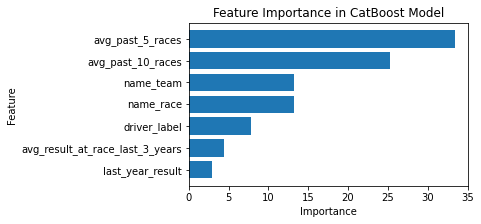

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importance values
feature_importance = model.get_feature_importance()

# Get feature names from the predictors
feature_names = X.columns

# Combine into a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(5, 3))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in CatBoost Model')
plt.show()


In [25]:
# Step 1: Add a placeholder for Qatar Grand Prix in 2024
drivers_to_compare = ['33. Verstappen', '4. Norris', '44. Hamilton', '81. Piastri', '16. Leclerc', '55. Sainz', '11. Pérez', '63. Russell']  # Example driver labels

last_race = 'Qatar Grand Prix'
qatar_race_name = "Abu Dhabi Grand Prix"
qatar_race_2024_id = races['raceId'].max() + 1  # Assign a new raceId
qatar_race_2024 = pd.DataFrame([{
    'raceId': qatar_race_2024_id,
    'year': 2024,
    'name_race': qatar_race_name,
    'round': races['round'].max() + 1  # Next round
}])
races = pd.concat([races, qatar_race_2024], ignore_index=True)

# Step 2: Create placeholders for drivers and teams for Qatar 2024
qatar_drivers = all_results # Get the latest driver records


# Step 3: Calculate predictors for Qatar
qatar_drivers['avg_past_5_races'] = qatar_drivers.groupby('driverId')['positionOrder'].apply(lambda x: x.rolling(window=5, min_periods=1).mean())
qatar_drivers['avg_past_10_races'] = qatar_drivers.groupby('driverId')['positionOrder'].apply(lambda x: x.rolling(window=10, min_periods=1).mean())


last_year = []
for i,row in qatar_drivers.iterrows():

    ly = all_results[(all_results.name_race == qatar_race_name) & (all_results.year == 2023) & (all_results.driverId == row.driverId)].positionOrder
    if len(ly)>0:
        
        last_year.append(ly.iloc[0])
    else:
        last_year.append(np.nan)

qatar_drivers['last_year_result'] = last_year

last_3_year = []
for i,row in qatar_drivers.iterrows():

    ly = all_results[(all_results.name_race == qatar_race_name) & (all_results.driverId == row.driverId)].positionOrder
    if len(ly)>0:
        last_3_year.append(ly.mean())
    else:
        last_3_year.append(np.nan)

qatar_drivers['avg_result_at_race_last_3_years'] = last_3_year       
        

last_race_id = all_results.iloc[-1].raceId

qatar_drivers = qatar_drivers.sort_values(by=['year','round', 'driverId'])
qatar_drivers = qatar_drivers.groupby('driverId').last().reset_index() 
qatar_drivers = qatar_drivers[qatar_drivers.raceId == last_race_id]
qatar_drivers['name_race'] = qatar_race_name
qatar_drivers['raceId'] = qatar_race_2024_id  # Assign Qatar raceId
qatar_drivers['year'] = 2024
qatar_drivers['round'] = qatar_race_2024['round'].values[0]


# Ensure categorical columns are encoded correctly
qatar_drivers['name_team'] = qatar_drivers['name_team'].astype('category')
qatar_drivers['name_race'] = qatar_drivers['name_race'].astype('category')
qatar_drivers['driver_label'] = qatar_drivers['driver_label'].astype('category')

# Step 4: Predict finishing positions for Qatar
qatar_drivers['predicted_position'] = model.predict(qatar_drivers[['avg_past_5_races', 'avg_past_10_races', 'last_year_result', 'avg_result_at_race_last_3_years', 'name_team', 'name_race', 'driver_label']])

# Step 5: Rank drivers by predicted positions
qatar_predictions = qatar_drivers[['driver_label', 'avg_past_5_races', 'avg_past_10_races', 'last_year_result', 'avg_result_at_race_last_3_years','predicted_position']].sort_values(by='predicted_position').reset_index(drop=True)
qatar_predictions['predicted_rank'] = qatar_predictions.index + 1

# Display predictions
qatar_predictions[qatar_predictions.driver_label.isin(drivers_to_compare)]


,driver_label,avg_past_5_races,avg_past_10_races,last_year_result,avg_result_at_race_last_3_years,predicted_position,predicted_rank
0,33. Verstappen,3.2,3.5,1.0,1.000000,2.120758,1
1,16. Leclerc,3.0,2.9,2.0,4.666667,2.549263,2
2,63. Russell,4.0,6.1,3.0,8.666667,3.898336,3
3,4. Norris,5.6,4.2,5.0,6.000000,4.514251,4
4,81. Piastri,6.2,4.3,6.0,6.000000,4.934116,5
5,55. Sainz,5.6,6.8,18.0,8.333333,5.451862,6
6,44. Hamilton,9.6,7.7,9.0,9.666667,6.896194,7
10,11. Pérez,12.4,11.0,4.0,7.333333,11.372161,11


In [26]:
# Example: Compare SHAP values for multiple drivers

for driver_label in drivers_to_compare:
    driver_data = qatar_drivers[qatar_drivers['driver_label'] == driver_label]
    if len(driver_data) != 1:
        print(f"Error: Multiple or no rows found for {driver_label}!")
        continue

    # Extract features for the driver
    driver_features = driver_data[['avg_past_5_races', 'avg_past_10_races', 'last_year_result', 'avg_result_at_race_last_3_years','name_team', 'name_race', 'driver_label']]

    # Calculate SHAP values
    shap_values = model.get_feature_importance(Pool(driver_features, cat_features=[4, 5, 6]), type="ShapValues")[0]

    # Separate base value and contributions
    base_value = shap_values[-1]
    contributions = shap_values[:-1]
    predicted_position = base_value + contributions.sum()

    # Display results
    print(f"\nDriver: {driver_label}")
    print(f"Base Value (Bias): {base_value:.4f}")
    print(f"Predicted Position: {predicted_position:.4f}")
    print("Feature Contributions:")
    for feature, contribution in zip(['avg_past_5_races', 'avg_past_10_races', 'last_year_result', 'avg_result_at_race_last_3_years', 'name_team', 'name_race', 'driver_label'], contributions):
        print(f"  {feature}: {contribution:.4f}")



Driver: 33. Verstappen
Base Value (Bias): 9.8001
Predicted Position: 2.1208
Feature Contributions:
  avg_past_5_races: -3.0394
  avg_past_10_races: -1.7005
  last_year_result: -0.3006
  avg_result_at_race_last_3_years: -0.2023
  name_team: -1.8442
  name_race: -0.0560
  driver_label: -0.5363

Driver: 4. Norris
Base Value (Bias): 9.8001
Predicted Position: 4.5143
Feature Contributions:
  avg_past_5_races: -1.7925
  avg_past_10_races: -1.9028
  last_year_result: 0.0464
  avg_result_at_race_last_3_years: -0.2230
  name_team: -0.9001
  name_race: -0.1494
  driver_label: -0.3645

Driver: 44. Hamilton
Base Value (Bias): 9.8001
Predicted Position: 6.8962
Feature Contributions:
  avg_past_5_races: -0.1435
  avg_past_10_races: -0.8265
  last_year_result: 0.0138
  avg_result_at_race_last_3_years: -0.1072
  name_team: -1.5742
  name_race: -0.0817
  driver_label: -0.1848

Driver: 81. Piastri
Base Value (Bias): 9.8001
Predicted Position: 4.9341
Feature Contributions:
  avg_past_5_races: -1.7887
  

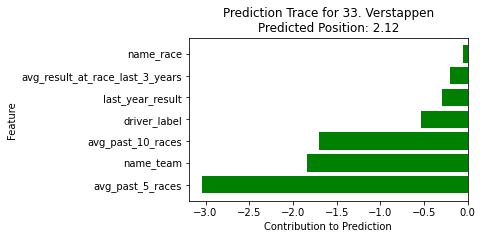

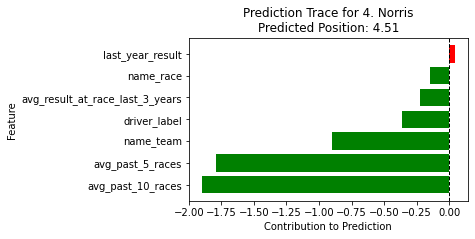

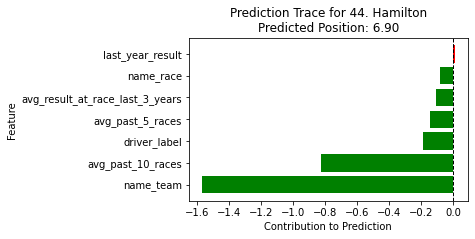

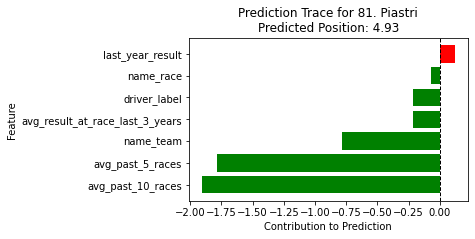

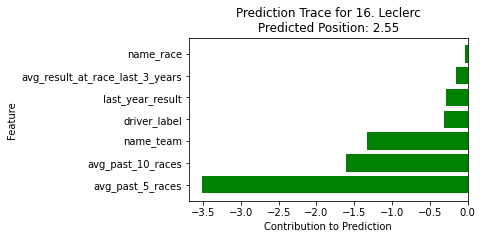

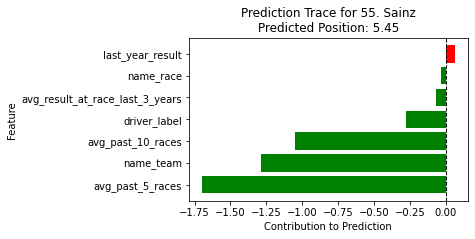

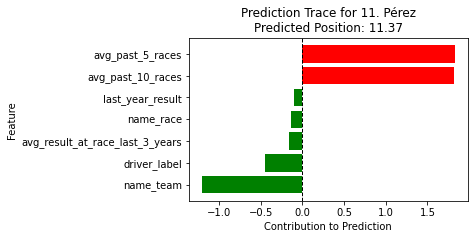

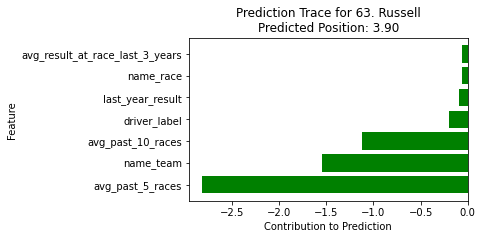

In [27]:
def plot_shap_values(driver_label, driver_data, model):
    # Extract features for the driver
    driver_features = driver_data[['avg_past_5_races', 'avg_past_10_races', 'last_year_result', 'avg_result_at_race_last_3_years', 'name_team', 'name_race', 'driver_label']]
    
    # Calculate SHAP values
    shap_values = model.get_feature_importance(Pool(driver_features, cat_features=[4, 5, 6]), type="ShapValues")[0]

    # Separate base value and contributions
    base_value = shap_values[-1]
    contributions = shap_values[:-1]
    predicted_position = base_value + contributions.sum()

    # Create a DataFrame for the contributions
    feature_names = ['avg_past_5_races', 'avg_past_10_races', 'last_year_result', 'avg_result_at_race_last_3_years', 'name_team', 'name_race', 'driver_label']
    trace_df = pd.DataFrame({
        'Feature': feature_names,
        'Contribution': contributions
    }).sort_values(by='Contribution', ascending=False)

    # Plot the contributions
    plt.figure(figsize=(5, 3))
    bar_colors = ['green' if c < 0 else 'red' for c in trace_df['Contribution']]
    plt.barh(trace_df['Feature'], trace_df['Contribution'], color=bar_colors, align='center')
    plt.gca().invert_yaxis()  # Most important feature at the top
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
    plt.xlabel('Contribution to Prediction')
    plt.ylabel('Feature')
    plt.title(f'Prediction Trace for {driver_label}\nPredicted Position: {predicted_position:.2f}')
    plt.show()
    
    
for driver_label in drivers_to_compare:
    driver_data = qatar_drivers[qatar_drivers['driver_label'] == driver_label]
    plot_shap_values(driver_label, driver_data, model)
    

In [60]:
features = ['avg_past_5_races', 'avg_past_10_races', 'last_year_result', 'avg_result_at_race_last_3_years', 'name_team', 'name_race', 'driver_label']

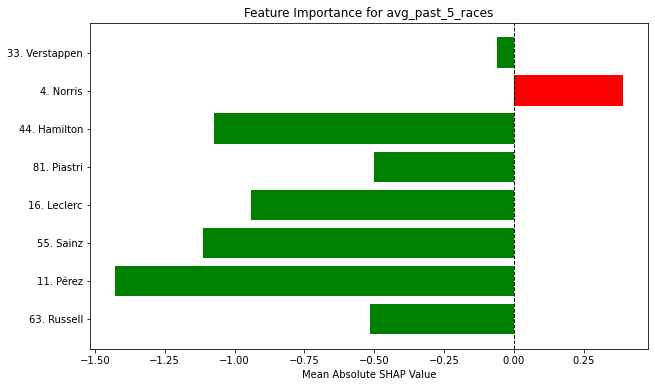

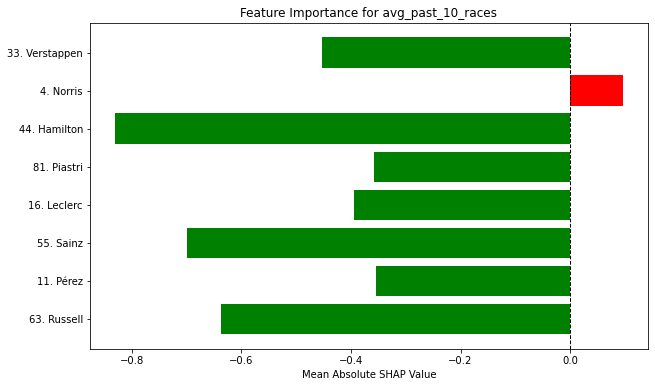

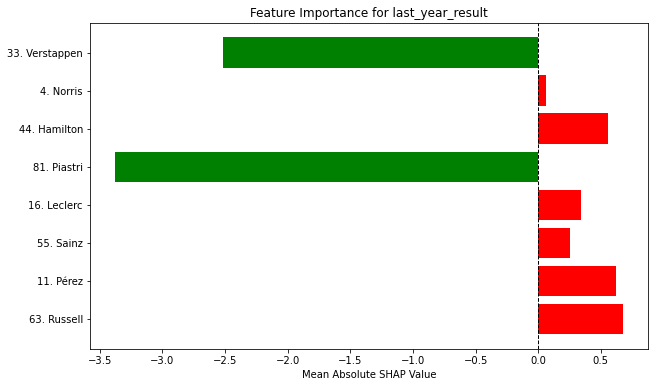

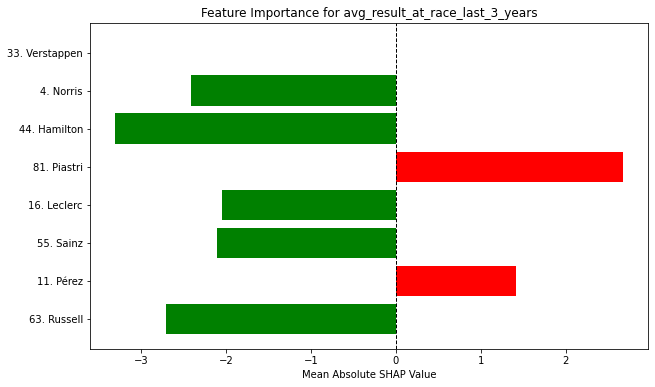

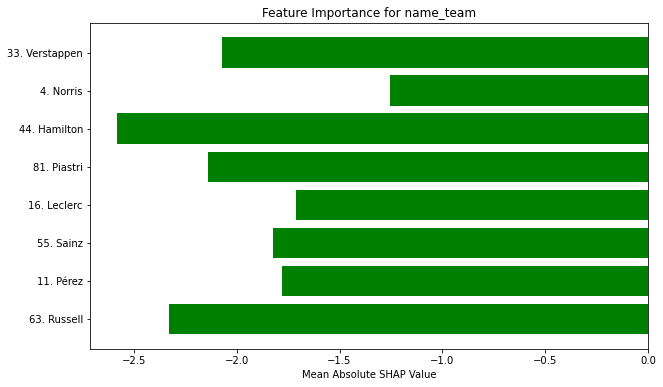

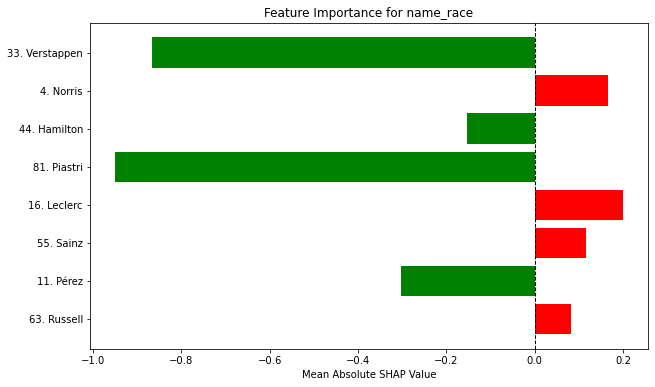

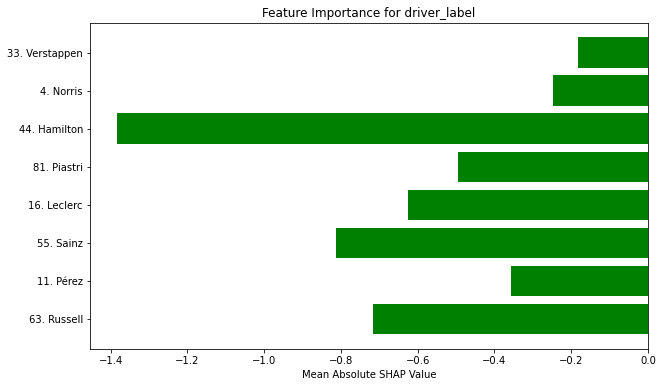

In [82]:
# Get SHAP values for the entire dataset
shap_values_all = model.get_feature_importance(Pool(qatar_drivers[features], cat_features=[4, 5, 6]), type="ShapValues")

# SHAP values include an additional column for the base value (bias term), exclude it
shap_values = shap_values_all[:, :-1]  # Remove the last column (base value)

# Step 2: Aggregate SHAP values per driver
shap_df = pd.DataFrame(shap_values, columns=features)
shap_df['driver'] = qatar_drivers['driver_label'].values
shap_df = shap_df[shap_df.driver.isin(drivers_to_compare)]
# Group by driver and calculate mean absolute SHAP value for each feature
shap_by_driver = shap_df

# Step 3: Plot bar charts for each driver

for feature in features:
    shap_values_driver = shap_by_driver[feature]
    plt.figure(figsize=(10, 6))
    bar_colors = ['green' if value < 0 else 'red' for value in shap_values_driver]
    plt.barh(drivers_to_compare, shap_values_driver, color=bar_colors, align='center')
    plt.gca().invert_yaxis()  # Most important feature at the top
    plt.xlabel('Mean Absolute SHAP Value')
    plt.title(f'Feature Importance for {feature}')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
    plt.show()

In [81]:
features

['avg_past_5_races',
 'avg_past_10_races',
 'last_year_result',
 'avg_result_at_race_last_3_years',
 'name_team',
 'name_race',
 'driver_label']